In [1]:
# different by splitting to train test valid (here valid and test are switched)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import time
import warnings
import torch.nn as nn
import pickle
from dataset_loader import *
from utils import *
import pandas as pd
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
from retrain_utils import *

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
dataset_name = 'sentiment'
ds = get_ds(dataset_name)

In [4]:
test_valid = ds['test'].train_test_split(0.5)
ds = DatasetDict({
    'train': ds['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [5]:
model_name =  'huawei-noah/TinyBERT_General_4L_312D'
folder_name = 'tinybert'

In [6]:
retrain_utils = RetrainUtils(model_name, dataset_name)
added_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.ADD)
removed_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.REMOVE)
replaced_train = retrain_utils.replace_sentences(ds['train'].to_pandas(), RetrainAction.REPLACE)

In [9]:
ds['train'] = removed_train

In [10]:
set_seed()
model = load_model(model_name)
tokenized_data = tokenize_dataset(ds, tokenizer_name=model_name, max_length = 64)
train(model, tokenized_data, path=f'{folder_name}/{dataset_name}/check', num_train_epochs=10)
model.save_pretrained(f'{folder_name}/{dataset_name}/updated_model2')

loading configuration file config.json from cache at /home/almr16/.cache/huggingface/hub/models--huawei-noah--TinyBERT_General_4L_312D/snapshots/34707a33cd59a94ecde241ac209bf35103691b43/config.json
Model config BertConfig {
  "_name_or_path": "huawei-noah/TinyBERT_General_4L_312D",
  "attention_probs_dropout_prob": 0.1,
  "cell": {},
  "classifier_dropout": null,
  "emb_size": 312,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 1200,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "pre_trained": "",
  "structure": [],
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /home/almr16/.cache/huggingface/hub/models--huawei-noah--TinyBERT_General_4L_312

  0%|          | 0/7708 [00:00<?, ?ex/s]

  0%|          | 0/1044 [00:00<?, ?ex/s]

  0%|          | 0/1043 [00:00<?, ?ex/s]

PyTorch: setting up devices
***** Running training *****
  Num examples = 7708
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2410


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.398342,0.818008
2,No log,0.398246,0.825670
3,0.428800,0.474079,0.811303
4,0.428800,0.500788,0.823755
5,0.238900,0.535552,0.828544
6,0.238900,0.629864,0.825670
7,0.140000,0.716424,0.827586
8,0.140000,0.781541,0.830460
9,0.085400,0.849335,0.831418
10,0.085400,0.847648,0.829502


***** Running Evaluation *****
  Num examples = 1044
  Batch size = 32
Saving model checkpoint to tinybert/sentiment/check/checkpoint-241
Configuration saved in tinybert/sentiment/check/checkpoint-241/config.json
Model weights saved in tinybert/sentiment/check/checkpoint-241/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1044
  Batch size = 32
Saving model checkpoint to tinybert/sentiment/check/checkpoint-482
Configuration saved in tinybert/sentiment/check/checkpoint-482/config.json
Model weights saved in tinybert/sentiment/check/checkpoint-482/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1044
  Batch size = 32
Saving model checkpoint to tinybert/sentiment/check/checkpoint-723
Configuration saved in tinybert/sentiment/check/checkpoint-723/config.json
Model weights saved in tinybert/sentiment/check/checkpoint-723/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1044
  Batch size = 32
Saving model checkpoint to tinybert/sentiment/c

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

### saved best model's folder as 'updated_model'

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(f'{folder_name}/{dataset_name}/updated_model2', num_labels=2, torchscript=True).to(device)
model = model.eval()

In [13]:
orig_model = AutoModelForSequenceClassification.from_pretrained(f'{folder_name}/{dataset_name}/model2', num_labels=2, torchscript=True).to(device)
orig_model = orig_model.eval()

loading configuration file tinybert/sentiment/model2/config.json
Model config BertConfig {
  "_name_or_path": "tinybert/sentiment/model2",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "cell": {},
  "classifier_dropout": null,
  "emb_size": 312,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 1200,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "pre_trained": "",
  "problem_type": "single_label_classification",
  "structure": [],
  "torch_dtype": "float32",
  "torchscript": true,
  "transformers_version": "4.23.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tinybert/sentiment/model2/pytorch_model.bin
All model checkpoint weights were used when initia

In [ ]:
tokenized_data = tokenize_dataset(ds, tokenizer_name=model_name, max_length = 64)

In [36]:
train(orig_model, tokenized_data, path=f'{folder_name}/{dataset_name}', evaluate = True)

PyTorch: setting up devices
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 32


{'eval_loss': 0.33094853162765503,
 'eval_accuracy': 0.892,
 'eval_runtime': 0.3967,
 'eval_samples_per_second': 2520.967,
 'eval_steps_per_second': 80.671}

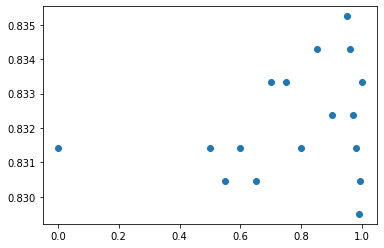

In [14]:
ths = [0.0, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.96, 0.97, 0.98, 0.99, 0.993, 1]
accs = []
for th in ths:
    ensemble = Ensemble(model, orig_model, th)
    acc = calc_accuracy(ensemble, ds['test'], tokenizer)[0]
    accs.append(acc)
_ = plt.scatter(ths, accs)

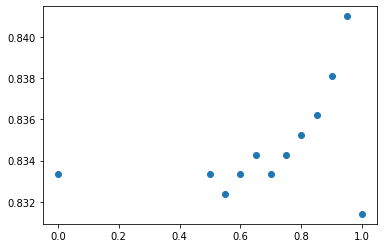

In [15]:
ths = [0.0, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1]
accs = []
for th in ths:
    ensemble = Ensemble(orig_model, model, th)
    acc = calc_accuracy(ensemble, ds['test'], tokenizer)[0]
    accs.append(acc)
_ = plt.scatter(ths, accs)

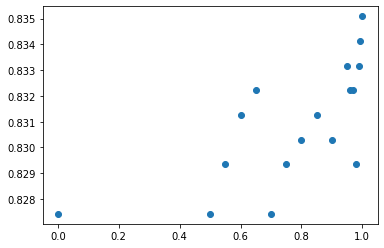

In [16]:
ths = [0.0, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.96, 0.97, 0.98, 0.99, 0.993, 1]
accs = []
for th in ths:
    ensemble = Ensemble(model, orig_model, th)
    acc = calc_accuracy(ensemble, ds['valid'], tokenizer)[0]
    accs.append(acc)
_ = plt.scatter(ths, accs)

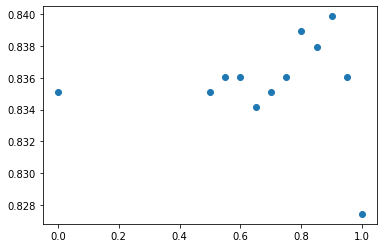

In [17]:
ths = [0.0, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8, 0.85, 0.9 , 0.95, 1]
accs = []
for th in ths:
    ensemble = Ensemble(orig_model, model, th)
    acc = calc_accuracy(ensemble, ds['valid'], tokenizer)[0]
    accs.append(acc)
_ = plt.scatter(ths, accs)

In [ ]:
def predict_sentences(sentences, m):
    encoded = [[101] +[tokenizer._convert_token_to_id_with_added_voc(token) for token in tokens] + [102]         
               for tokens in sentences]
    to_pred = torch.tensor(encoded, device=device)
    outputs = m(to_pred)[0]
    print(outputs)
    return torch.argmax(outputs, dim=1).cpu().numpy()

In [13]:
predict_sentences([tokenizer.tokenize("i hate movies")])

tensor([[ 1.7911, -1.7094]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([0])

In [14]:
predict_sentences([tokenizer.tokenize("i love movies")])

tensor([[-2.3436,  2.2181]], device='cuda:0', grad_fn=<AddmmBackward0>)


array([1])